In [ ]:
from pathlib import Path
import shutil
from tqdm import tqdm
import random

In [ ]:
def make_small_test_split(root_dir: str, to_keep: int = 0.1):
    root_path = Path(root_dir)
    full_images_dir = root_path / "images"
    full_labels_dir = root_path / "labels"

    small_images_dir = root_path.parent / "images"
    small_labels_dir = root_path.parent / "labels"

    small_images_dir.mkdir(parents=True, exist_ok=True)
    small_labels_dir.mkdir(parents=True, exist_ok=True)

    images = list(full_images_dir.glob("*.jpg"))
    images_count = len(images)

    new_images_count = int(images_count * to_keep)

    new_images = random.sample(images, new_images_count)

    for new_image in tqdm(new_images, desc="Making smaller test split..."):
        shutil.copy(new_image, small_images_dir / new_image.name)
        label_file = full_labels_dir / f"{new_image.stem}.txt"
        shutil.copy(label_file, small_labels_dir / label_file.name)

    print(f"New split has {new_images_count} images.")


make_small_test_split(
    "D:\\studia\\semestr_8\\zespolowy_projekt_badawczy\\qgis-yolo-plugin\\train\\dataset\\DOTANA\\test\\full"
)

In [8]:
SHIPS_CLASSES = {
    "Other Ship": 1,
    "Warship": 2,
    "Merchant": 3,
    "Dock": 4,
}

SHIPS_CLASSES_REVERSED = {v: k for k, v in SHIPS_CLASSES.items()}

In [ ]:
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
import json

ships_val_labels = "D:\\stuff\\datasets\\ShipRSImageNet\\annotations\\ShipRSImageNet_bbox_val_level_1.json"
ships_train_labels = "D:\\stuff\\datasets\\ShipRSImageNet\\annotations\\ShipRSImageNet_bbox_train_level_1.json"


def load_and_prepare_coco_data(json_path):
    with open(json_path) as f:
        data = json.load(f)

    image_id_to_filename = {image["id"]: image["file_name"] for image in data["images"]}
    annotations_by_filename = defaultdict(list)

    for ann in data["annotations"]:
        image_id = ann["image_id"]
        if image_id in image_id_to_filename:
            filename = image_id_to_filename[image_id]
            annotations_by_filename[filename].append(ann)

    return annotations_by_filename


def show_image_with_boxes_ships(image_path, object_name=None):
    print(f"Showing: {image_path}")
    val_data = load_and_prepare_coco_data(ships_val_labels)
    train_data = load_and_prepare_coco_data(ships_train_labels)
    all_annotations = {**val_data, **train_data}

    image_filename = Path(image_path).name
    annotations_for_this_image = all_annotations.get(image_filename, [])

    img = cv2.imread(str(image_path))

    for ann in annotations_for_this_image:
        class_id = ann["category_id"]
        cls_name = SHIPS_CLASSES_REVERSED.get(class_id)

        if object_name is None or cls_name == object_name:
            x, y, w, h = [int(v) for v in ann["bbox"]]
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(
                img, cls_name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2
            )

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

Showing: D:\stuff\datasets\ShipRSImageNet\images\100000772.jpg


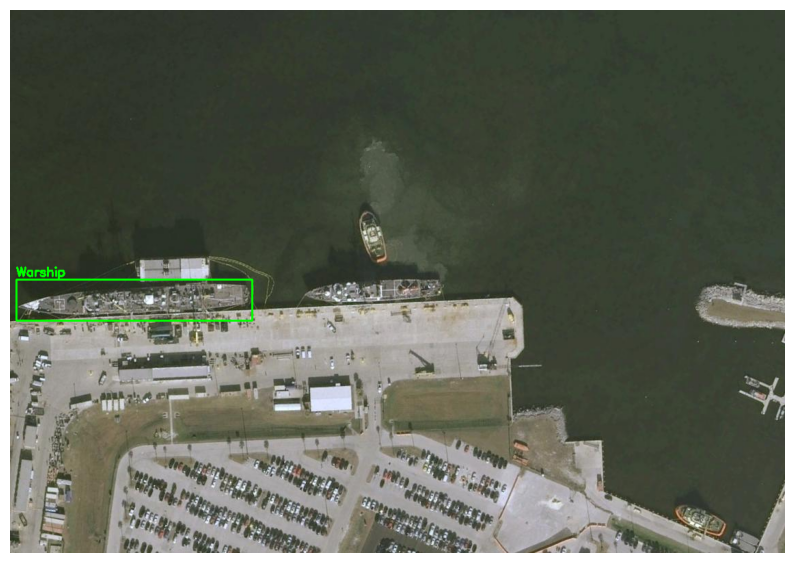

In [18]:
image_path = "D:\\stuff\\datasets\\ShipRSImageNet\\images\\100000772.jpg"
show_image_with_boxes_ships(image_path, "Warship")

In [ ]:
source_dir = Path("D:/stuff/datasets/DOTANA/DOTANA")
dest_dir = Path("D:/stuff/datasets/DOTANA/DOTANA_no_ships")
category_id_to_remove = 4

if dest_dir.exists():
    shutil.rmtree(dest_dir)

for split_dir in source_dir.iterdir():
    if not split_dir.is_dir():
        continue

    split = split_dir.name

    source_images_path = split_dir / "images"
    source_labels_path = split_dir / "labels"

    dest_split_path = dest_dir / split
    dest_images_path = dest_split_path / "images"
    dest_labels_path = dest_split_path / "labels"
    dest_images_path.mkdir(parents=True, exist_ok=True)
    dest_labels_path.mkdir(parents=True, exist_ok=True)

    label_files = list(source_labels_path.glob("*.txt"))

    for label_file in tqdm(label_files, desc=f"Processing {split}"):
        with open(label_file, "r") as f:
            has_ship = any(
                line.strip().startswith(f"{category_id_to_remove}") for line in f
            )

        if not has_ship:
            shutil.copy(label_file, dest_labels_path)
            source_image = source_images_path / f"{label_file.stem}.jpg"
            shutil.copy(source_image, dest_images_path)

Processing valid: 100%|██████████| 3630/3630 [01:52<00:00, 32.25it/s] 


In [ ]:
def copy_ship_files():
    old_train_label_path = Path("D:\\stuff\\datasets\\ShipRSImageNet\\annotations\\yolo_annot\\train1")
    old_val_label_path = Path("D:\\stuff\\datasets\\ShipRSImageNet\\annotations\\yolo_annot\\val1")
    old_image_path = Path("D:/stuff/datasets/ShipRSImageNet/images")
    new_dataset_path = Path("D:/stuff/datasets/ShipRSImageNet/ShipRSImageNet")

    all_label_files = list(old_train_label_path.glob("*.txt")) + list(old_val_label_path.glob("*.txt"))
    basenames = [p.stem for p in all_label_files]
    total_files = len(basenames)

    print(f"Found {total_files} unique image/label pairs.\n")

    new_images_path= new_dataset_path / "images"
    new_labels_path= new_dataset_path / "labels"
    new_images_path.mkdir(parents=True, exist_ok=True)
    new_labels_path.mkdir(parents=True, exist_ok=True)

    for basename in tqdm(basenames, desc="Copying files..."):
        src_image = old_image_path / f"{basename}.jpg"

        src_label_train = old_train_label_path / f"{basename}.txt"
        src_label_val = old_val_label_path / f"{basename}.txt"
        src_label = src_label_train if src_label_train.exists() else src_label_val

        dest_image = new_images_path / f"{basename}.jpg"
        dest_label = new_labels_path / f"{basename}.txt"

        if src_image.exists() and src_label.exists():
            shutil.copy(src_image, dest_image)
            shutil.copy(src_label, dest_label)

copy_ship_files()

Found 2748 unique image/label pairs.



Copying files...:   0%|          | 0/2748 [00:00<?, ?it/s]

Copying files...: 100%|██████████| 2748/2748 [00:07<00:00, 374.03it/s]


In [19]:
def remap_labels(line: str) -> str:
    # 1 0.40914 0.406989 0.407527 0.545161
    # class x_center y_center width height
    parts = line.strip().split()

    class_index = int(parts[0])

    mapping = {0: 0, 1: 1, 2: 0}
    if class_index not in mapping:
        return ""

    new_class_index = mapping[class_index]

    coords = list(map(float, parts[1:]))

    return f"{new_class_index} " + " ".join(f"{c:.6f}" for c in coords)


def convert_ships_dataset(root_dir: str) -> None:
    dior_path = Path(root_dir)

    labels_dir = dior_path / "labels"

    label_files = list(labels_dir.iterdir())
    for label_file in tqdm(label_files, desc="Converting SHIPS labels..."):
        with open(label_file) as f:
            lines = f.readlines()

        new_label_content = []
        for line in lines:
            hbb_line = remap_labels(line)
            if hbb_line:
                new_label_content.append(hbb_line)

        with open(label_file, "w") as f:
            f.write("\n".join(new_label_content))


convert_ships_dataset("D:\\stuff\\datasets\\ShipRSImageNet\\ShipRSImageNet")

Converting SHIPS labels...: 100%|██████████| 2748/2748 [00:17<00:00, 153.58it/s]


In [ ]:
from sklearn.model_selection import train_test_split

def make_ships_yolo_split():
    old_label_path = Path("D:/stuff/datasets/ShipRSImageNet/ShipRSImageNet/labels")
    old_image_path = Path("D:/stuff/datasets/ShipRSImageNet/ShipRSImageNet/images")
    new_dataset_path = Path("D:/stuff/datasets/ShipRSImageNet/ShipRSImageNet")

    all_label_files = list(old_label_path.glob("*.txt"))
    basenames = [p.stem for p in all_label_files]
    total_files = len(basenames)

    train_basenames, val_test_basenames = train_test_split(
        basenames, test_size=0.2, random_state=42
    )

    val_basenames, test_basenames = train_test_split(
        val_test_basenames, test_size=0.5, random_state=42
    )

    print(f"Train set size: {len(train_basenames)} files ({len(train_basenames) / total_files:.0%})")
    print(f"Validation set size: {len(val_basenames)} files ({len(val_basenames) / total_files:.0%})")
    print(f"Test set size: {len(test_basenames)} files ({len(test_basenames) / total_files:.0%})\n")

    splits = ["train", "valid", "test"]
    for split in splits:
        (new_dataset_path / split / "images").mkdir(parents=True, exist_ok=True)
        (new_dataset_path / split / "labels").mkdir(parents=True, exist_ok=True)

    def copy_files(basenames_list, split_name):
        for basename in tqdm(basenames_list, desc=f"Copying {split_name} set"):
            src_image = old_image_path / f"{basename}.jpg"
            src_label = old_label_path / f"{basename}.txt"

            dest_image = new_dataset_path / split_name / "images" / f"{basename}.jpg"
            dest_label = new_dataset_path / split_name / "labels" / f"{basename}.txt"

            if src_image.exists() and src_label.exists():
                shutil.copy(src_image, dest_image)
                shutil.copy(src_label, dest_label)
            else:
                print(f"Warning: Could not find source files for basename '{basename}'. Skipping.")

    copy_files(train_basenames, "train")
    copy_files(val_basenames, "valid")
    copy_files(test_basenames, "test")

make_ships_yolo_split()

Train set size: 2198 files (~80%)
Validation set size: 275 files (~10%)
Test set size: 275 files (~10%)



Copying test set: 100%|██████████| 275/275 [00:05<00:00, 52.39it/s]
